In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from keras.layers import InputLayer, Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization, Input, Layer, RandomFlip, RandomRotation, Dropout
from keras.models import Model
from keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC
from sklearn.metrics import confusion_matrix, roc_curve
from keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
from keras.regularizers  import L2
import seaborn as sns
import wandb 
from wandb.keras import WandbCallback
import os

2024-04-14 03:27:37.685446: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
os.environ['WANDB_NOTEBOOK_NAME'] = "4_11_malaria_detection.ipynb"
print(os.environ['WANDB_NOTEBOOK_NAME'])

4_11_malaria_detection.ipynb


## Wandb install and login

In [3]:
%%bash
# pip install wandb
wandb login 8f3b38be2bb218efc0dae18a776cae17e897a2d5


wandb: Appending key for api.wandb.ai to your netrc file: /home/kervin/.netrc


In [4]:
%%bash

wandb login

wandb: Currently logged in as: kervin5. Use `wandb login --relogin` to force relogin


In [5]:
%%bash
BROWSER=google-chrome-stable

In [6]:
# wandb.init(project="Malaria-Detection", entity="kervin5")
WANDB_CONFIG = {
    "learning_rate": 0.001,
    "epochs": 3,
    "batch_size": 128,
    "dropout": 0.0,
    "im_size": 224,
    "regularization_rate": 0.0,
    "n_filters": 6,
    "kernel_size": 3,
    "n_strides": 1,
    "pool_size": 2,
    "n_dense_1": 128,
    "n_dense_2": 64,
}

In [7]:
wandb.config = WANDB_CONFIG

## Data Preparation

### Dataset versioning

In [8]:
dataset, dataset_info = tfds.load('malaria', with_info=True, as_supervised=True, shuffle_files=True, split=['train'])

2024-04-14 03:27:44.331837: W tensorflow/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27558 [00:00<?, ? examples/s]

Shuffling /home/kervin/tensorflow_datasets/malaria/1.0.0.incompleteQRG6C9/malaria-train.tfrecord*...:   0%|   …

Dataset malaria downloaded and prepared to /home/kervin/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


2024-04-14 03:28:19.152320: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-14 03:28:19.169284: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-14 03:28:19.169458: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [9]:
print(dataset)

[<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>]


In [10]:
print(dataset_info)

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir=PosixGPath('/tmp/tmppydc0qk1tfds'),
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin blood smear images},


In [12]:
k = 0


# Saving the dataset to generate the npz files for weigths and biases
for data in dataset[0]:
    with open('dataset/malaria_' + str(k) + '.npz', mode='wb') as file:
        np.savez_compressed(file, data[0].numpy(), data[1].numpy())
        

    k += 1

In [13]:
def load_original_data():
    with wandb.init(project="Malaria-Detection", entity="kervin5") as run:
        original_data = wandb.Artifact(name="new_dataset", 
                                       
                                    type="raw_data",
                                    description="The Malaria dataset contains a total of 27,558 cell images with equal instances of parasitized and uninfected cells. The images are RGB with a size of 224x224 pixels.",
                                    metadata={
                                        "source": "TFDS",
                                        "homepage": "https://lhncbc.nlm.nih.gove/publication/pub9932",
                                        "version": "1.0.0",
                                        "dowload_size": "337.08 MB"
                                    })
        original_data.add_dir('dataset')

        run.log_artifact(original_data)

In [14]:
# load_original_data() # This creates a new artifact in the project using the original dataset

In [15]:
with wandb.init(project="Malaria-Detection", entity="kervin5") as run:
    # When using file versioning with weight and biases, we can use the artifact to download the dataset instead of using tfds
    artifact = run.use_artifact('kervin5/Malaria-Detection/new_dataset:v0', type='raw_data')
    artifact_dir = artifact.download()
    print(artifact_dir)

wandb: Currently logged in as: kervin5. Use `wandb login --relogin` to force relogin


wandb: Downloading large artifact new_dataset:v0, 388.82MB. 27559 files... 
wandb:   27559 of 27559 files downloaded.  
Done. 0:0:54.8


/home/kervin/Coding/machine_learning/20_tensorflow_projects/artifacts/new_dataset:v0


In [16]:
# for data in dataset['train'].take(2):
#     image = data[0]
#     label = data[1]
#     plt.imshow(image)

In [17]:
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
    DATASET_SIZE = len(dataset)

    train_dataset = dataset.take(int(TRAIN_RATIO * DATASET_SIZE))

    val_test_dataset = dataset.skip(int(TRAIN_RATIO * DATASET_SIZE))
    val_dataset = val_test_dataset.take(int(VAL_RATIO * DATASET_SIZE))

    test_dataset = val_test_dataset.skip(int(VAL_RATIO * DATASET_SIZE)).take(int(TEST_RATIO * DATASET_SIZE))
    return train_dataset, val_dataset, test_dataset

In [18]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)

In [19]:
# print(list(train_dataset.take(1).as_numpy_iterator()),
#         list(val_dataset.take(1).as_numpy_iterator()),
#         list(test_dataset.take(1).as_numpy_iterator()), sep='\n')

## Dataset Visualization

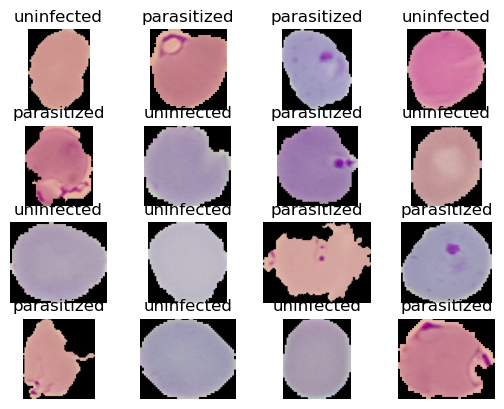

In [20]:
for i, (image, label) in enumerate(train_dataset.take(16)):
    plt.subplot(4, 4, i + 1)
    plt.imshow(image)
    plt.title(dataset_info.features['label'].names[label])
    # Same as plt.title(dataset_info.features['label'].int2str(label))
    plt.axis('off')

## Data Preprocessing

In [21]:
wandb.init(project="Malaria-Detection", entity="kervin5")
wandb.config = WANDB_CONFIG
CONFIGURATION = wandb.config
IM_SIZE = CONFIGURATION['im_size']


In [22]:
def resize_rescale(image, label, IM_SIZE=IM_SIZE):
    image = tf.image.resize(image, (IM_SIZE, IM_SIZE)) / 255.0
    return image, label

In [23]:
def preprocess_data():
    with wandb.init(project="Malaria-Detection", entity="kervin5") as run:
        artifact = run.use_artifact('kervin5/Malaria-Detection/new_dataset:v0', type='raw_data')
        artifact_directory = artifact.download()

        preprocess_data = wandb.Artifact(name="preprocessed_dataset", 
                                       
                                    type="preprocessed_data",
                                    description="A preprocessed version of the Malaria dataset. The images are resized to 224x224 pixels and normalized.",
                                    )
        

        dataset_x = []
        dataset_y = []

        for f in os.listdir(artifact_directory)[:100]:
            with open(os.path.join(artifact_directory, f), 'rb') as file:
                data = np.load(file)
                item_data = resize_rescale(data['arr_0'], data['arr_1'])
                dataset_x.append(item_data[0])
                dataset_y.append(item_data[1])

        

        with preprocess_data.new_file("prep_dataset.npz", mode="wb") as file:
            np.savez_compressed(file, dataset_x, dataset_y)

        run.log_artifact(preprocess_data)

In [24]:
preprocess_data()

wandb: Downloading large artifact new_dataset:v0, 388.82MB. 27559 files... 
wandb:   27559 of 27559 files downloaded.  
Done. 0:0:55.9


### Data splitting

In [25]:
def split_data():
    with wandb.init(project="Malaria-Detection", entity="kervin5") as run:
        artifact = run.use_artifact('kervin5/Malaria-Detection/preprocessed_dataset:v0', type='preprocessed_data')
        artifact_directory = artifact.download()

        train_data = wandb.Artifact(name="train_dataset", 
                                    type="preprocessed_data",
                                    description="The training dataset for the Malaria detection model. The images are resized to 224x224 pixels and normalized.",
                                    )
        
        val_data = wandb.Artifact(name="val_dataset",
                                      type="preprocessed_data",
                                        description="The validation dataset for the Malaria detection model. The images are resized to 224x224 pixels and normalized.",
                                        )

        test_data = wandb.Artifact(name="test_dataset",
                                       type="preprocessed_data",
                                         description="The test dataset for the Malaria detection model. The images are resized to 224x224 pixels and normalized.",
                                         )
        
        with open(os.path.join(artifact_directory, 'prep_dataset.npz'), 'rb') as file:
            data = np.load(file, allow_pickle=True)
            
            train_split = 0.8
            val_split = 0.1
            test_split = 0.1

            data_len = len(data['arr_0'])

            train_arr = data['arr_0'][:int(train_split * data_len)]
            val_arr = data['arr_0'][int(train_split * data_len):int((train_split + val_split) * data_len)]
            test_arr = data['arr_0'][int((train_split + test_split) * data_len):]

            with train_data.new_file("train_dataset.npz", mode="wb") as file:
                np.savez_compressed(file, train_arr)

            with val_data.new_file("val_dataset.npz", mode="wb") as file:
                np.savez_compressed(file, val_arr)

            with test_data.new_file("test_dataset.npz", mode="wb") as file:
                np.savez_compressed(file, test_arr)

        run.log_artifact(train_data)
        run.log_artifact(val_data)
        run.log_artifact(test_data)



In [26]:
split_data()

wandb:   1 of 1 files downloaded.  


### Data Augmentation

In [27]:
# Augmentations using tf.image augment

def augment(image, label):
    image, label = resize_rescale(image, label)
    image = tf.image.rot90(image)
    # image = tf.image.adjust_saturation(image, saturation_factor=0.3)
    image = tf.image.flip_left_right(image)

    return image, label
    
# Augmentations using tf.keras.layers
# augment_layers = tf.keras.Sequential([

In [28]:
def augment_data():
    with wandb.init(project="Malaria-Detection", entity="kervin5") as run:
        artifact = run.use_artifact('kervin5/Malaria-Detection/train_dataset:v0', type='preprocessed_data')
        artifact_directory = artifact.download()

        augmented_data = wandb.Artifact(name="augmented_dataset",
                                       
                                    type="preprocessed_data",
                                    description="An augmented version of the Malaria dataset. The images are resized to 224x224 pixels and normalized.",
                                    )
        
        dataset_x = []
        dataset_y = []
        
        # This is missing the labels due to a possible bug in the previous step
        with open(os.path.join(artifact_directory, 'train_dataset.npz'), 'rb') as file:
            npz_arrays = np.load(file, allow_pickle=True)
            for i in range(len(npz_arrays['arr_0'])):
                augmented_image = tf.image.rot90(npz_arrays['arr_0'][i])
                augmented_image = tf.image.flip_left_right(augmented_image)
                dataset_x.append(augmented_image)

        with augmented_data.new_file("augmented_dataset.npz", mode="wb") as file:
            np.savez_compressed(file, dataset_x)


        run.log_artifact(augmented_data)


In [29]:
augment_data()

wandb:   1 of 1 files downloaded.  


In [30]:
def visualize(original, augmented):
    plt.subplot(1, 2, 1)
    plt.imshow(original)

    plt.subplot(1, 2, 2)
    plt.imshow(augmented)

In [31]:
original_image, label = next(iter(train_dataset))

In [32]:
augmented_image = tf.image.flip_left_right(original_image)
augmented_image = tf.image.flip_up_down(augmented_image)
augmented_image = tf.image.rot90(augmented_image)
augmented_image = tf.image.random_brightness(augmented_image, max_delta=0.5)
# augmented_image = tf.image.random_contrast(augmented_image, lower=0.2, upper=1.8)
# augmented_image = tf.image.random_saturation(augmented_image, lower=0.2, upper=1.8)
# augmented_image = tf.image.random_hue(augmented_image, max_delta=0.3)
# augmented_image = tf.image.central_crop(augmented_image, central_fraction=0.8)
augmented_image = tf.image.adjust_saturation(augmented_image, 3)

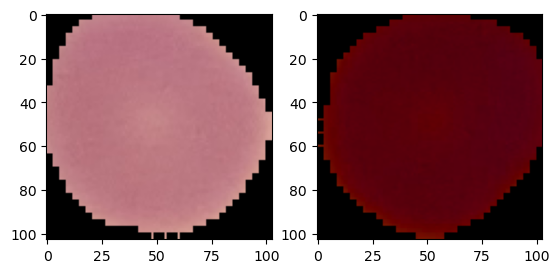

In [33]:
visualize(original_image, augmented_image)

In [34]:
test_dataset = test_dataset.map(resize_rescale)

In [35]:
for image, label in train_dataset.take(1):
    print(image, label)

tf.Tensor(
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]], shape=(151, 115, 3), dtype=uint8) tf.Tensor(1, shape=(), dtype=int64)


In [36]:
BATCH_SIZE = CONFIGURATION['batch_size']
REGULARIZATION_RATE = CONFIGURATION['regularization_rate']
DROPOUT_RATE = CONFIGURATION['dropout']
N_FILTERS = CONFIGURATION['n_filters']
KERNEL_SIZE = CONFIGURATION['kernel_size']
POOL_SIZE = CONFIGURATION['pool_size']
N_STRIDES = CONFIGURATION['n_strides']

train_dataset = train_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).map(augment).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_dataset = val_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).map(resize_rescale).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


## Model Creation

### Sequential API

In [37]:



# model = tf.keras.Sequential([
#     InputLayer(input_shape=(IM_SIZE, IM_SIZE, 3)),
#     Conv2D(filters=6, kernel_size=3, strides=1, padding='valid', activation='relu'),
#     BatchNormalization(),
#     MaxPool2D(pool_size=2, strides=2),

#     Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation='relu'),
#     BatchNormalization(),
#     MaxPool2D(pool_size=2, strides=2),

#     Flatten(),

#     Dense(1000, activation='relu'),
#     BatchNormalization(),
#     Dense(100, activation='relu'),
#     BatchNormalization(),
#     Dense(1, activation='sigmoid')
# ])

# model.summary()



### Functional API

In [38]:
func_input = Input(shape=(IM_SIZE, IM_SIZE, 3))

x = Conv2D(filters=N_FILTERS, kernel_size=KERNEL_SIZE, strides=N_STRIDES, padding='valid', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(REGULARIZATION_RATE))(func_input)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=POOL_SIZE, strides=N_STRIDES*2)(x)
x = tf.keras.layers.Dropout(DROPOUT_RATE)(x)

x = Conv2D(filters=N_FILTERS * 2 + 4, kernel_size=KERNEL_SIZE, strides=N_STRIDES, padding='valid', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(REGULARIZATION_RATE))(x)
x = BatchNormalization()(x)
output = MaxPool2D(pool_size=POOL_SIZE, strides=N_STRIDES)(x)

feature_extractor_model = Model(inputs=func_input, outputs=output, name='feature_extractor')
feature_extractor_model.summary()

Model: "feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 6)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 111, 111, 6)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)

In [39]:
# func_input = Input(shape=(IM_SIZE, IM_SIZE, 3))

# x = feature_extractor_model(func_input)
# x = Flatten()(x)

# x = Dense(1000, activation='relu')(x)
# x = BatchNormalization()(x)

# x = Dense(100, activation='relu')(x)
# x = BatchNormalization()(x)

# func_output = Dense(1, activation='sigmoid')(x)

# model = Model(inputs=func_input, outputs=func_output, name='malaria_detection')
# model.summary()



## Model Subclassing

In [40]:
class FeatureExtractor(Layer):
    def __init__(self, filters, kernel_size, strides, padding, activation, pool_size):
        super(FeatureExtractor, self).__init__()

        self.conv1 = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding, activation=activation)
        self.batch_1 = BatchNormalization()
        self.pool_1 = MaxPool2D(pool_size=pool_size, strides=2*strides)

        self.conv2 = Conv2D(filters=2*filters, kernel_size=kernel_size, strides=strides, padding=padding, activation=activation)
        self.batch_2 = BatchNormalization()
        self.pool_2 = MaxPool2D(pool_size=pool_size, strides=2*strides)


    def call(self, x, training):
        x = self.conv1(x)
        x = self.batch_1(x)
        x = self.pool_1(x)

        x = self.conv2(x)
        x = self.batch_2(x)
        x = self.pool_2(x)

        return x


feature_sub_classed = FeatureExtractor(8, 3, 1, 'valid', 'relu', 2)

In [41]:
# func_input = Input(shape=(IM_SIZE, IM_SIZE, 3))

# x = feature_sub_classed(func_input)
# x = Flatten()(x)

# x = Dense(1000, activation='relu')(x)
# x = BatchNormalization()(x)

# x = Dense(100, activation='relu')(x)
# x = BatchNormalization()(x)

# func_output = Dense(1, activation='sigmoid')(x)

# model = Model(inputs=func_input, outputs=func_output, name='malaria_detection')
# model.summary()

In [42]:
class LenetModel(Model):
    def __init__(self):
        super(LenetModel, self).__init__()

        self.feature_extractor = FeatureExtractor(8, 3, 1, 'valid', 'relu', 2)
        self.flatten = Flatten()
        self.dense_1 = Dense(1000, activation='relu')
        self.batch_1 = BatchNormalization()

        self.dense_2 = Dense(100, activation='relu')
        self.batch_2 = BatchNormalization()

        self.dense_3 = Dense(1, activation='sigmoid')

    def call(self, x, training):
        x = self.feature_extractor(x, training)
        x = self.flatten(x)

        x = self.dense_1(x)
        x = self.batch_1(x)

        x = self.dense_2(x)
        x = self.batch_2(x)

        return self.dense_3(x)


lenet_sub_classed_model = LenetModel()
lenet_sub_classed_model(tf.ones((1, IM_SIZE, IM_SIZE, 3)))
lenet_sub_classed_model.summary()

Model: "lenet_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_1 (Featu  multiple                  1488      
 reExtractor)                                                    
                                                                 
 flatten (Flatten)           multiple                  0         
                                                                 
 dense (Dense)               multiple                  46657000  
                                                                 
 batch_normalization_6 (Bat  multiple                  4000      
 chNormalization)                                                
                                                                 
 dense_1 (Dense)             multiple                  100100    
                                                                 
 batch_normalization_7 (Bat  multiple                  

2024-04-14 03:33:59.095353: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8907
2024-04-14 03:33:59.125208: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-14 03:33:59.125484: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-14 03:33:59.125500: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:109] Couldn't get ptxas version : FAILED_PRECONDITION: Couldn't get ptxas/nvlink version string: INTERNAL: Couldn't invoke ptxas --version
2024-04-14 03:33:59.125884: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-14 03:33:59.125926: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:318] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This mes

In [43]:
model = LenetModel()

metrics = [
    BinaryAccuracy(name='accuracy'),
    FalsePositives(name='fp'),
    FalseNegatives(name='fn'),
    TruePositives(name='tp'),
    TrueNegatives(name='tn'),
    Precision(name='precision'),
    Recall(name='recall'),
    AUC(name='auc')
]


LABELS = ['Uninfected','Parasitized']

model.compile(optimizer=tf.optimizers.legacy.Adam(learning_rate=CONFIGURATION['learning_rate']),
              loss=tf.keras.losses.binary_crossentropy,
              metrics=metrics)
              

In [44]:
# We can use this custom layer in place of Dense layer
# It's an example of how to create custom layers
class NeuralearnDense(Layer):
    def __init__(self, output_units, activation=None):
        super(NeuralearnDense, self).__init__()
        self.output_units = output_units
        self.activation = activation


    def build(self, input_features_shape):
        self.w = self.add_weight(shape=(input_features_shape[-1], self.output_units), trainable=True, initializer='random_normal')
        self.w = self.add_weight(shape=(self.output_units,), trainable=True, initializer='random_normal')

    def call(self, input_features):
        pre_output = tf.matmul(input_features, self.w) + self.b

        if self.activation == 'relu':
            return tf.math.maximum(pre_output, 0)
        elif self.activation == 'sigmoid':
            return tf.math.sigmoid(pre_output)
        else:
            return pre_output
        


## Callbacks

In [45]:
class LossCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        print('\nFor Epoch Number {} the model has a loss of {}'.format(epoch, logs['loss'])) 
    def on_batch_end(self, batch, logs=None):
        print('\nFor Batch Number {} the model has a loss of {}'.format(batch, logs['loss']))


### CSV Logger

In [46]:
csv_callback = CSVLogger('logs.csv', separator=',', append=False)

### Early Stopping

In [47]:
early_stopping_callback = EarlyStopping(monitor='val_loss',min_delta=0, patience=0, verbose=0, mode='auto', baseline=None, restore_best_weights=False)

### Learning Rate Scheduler

In [48]:
def scheduler(epoch, lr):
    if epoch <= 3:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
    
lr_scheduler_callback = LearningRateScheduler(scheduler, verbose=1)

### Model Checkpoint

In [49]:
checkpoint_callback = ModelCheckpoint('checkpoints/', monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', save_freq=3)

### Reduece Learning Rate on Plateau

In [50]:
plateau_callback = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2, verbose=1)

In [51]:
print(val_dataset)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [52]:
def generator(dataset):
    for x, y in dataset:
        yield x, y

## Model Training

### Hyperparameter Tuning

In [53]:
wandb.init(project="Malaria-Detection", entity="kervin5")

In [54]:
sweep_config = {
  "name" : "Malaria-Prediction-Sweep",
  "method" : "random",
  "metric": {
      "name" : "accuracy",
      "goal" : "maximize",
  },
  "parameters" : {
    
    "im_size": {
        "value" : 224,
    },

    "n_epochs": {
        "value" : 1,
    },
    
    "kernel_size": {
        "value" : 3,
    },

    "n_strides": {
        "value" : 1,
    },

    "pool_size": {
        "value" : 224,
    },
  
    "n_filters" : {
        "value" : 6,
    },
      
    "n_dense_1" : {
      "values" : [16, 32, 64, 128]
    },

    "n_dense_2" : {
      "values" : [16, 32, 64, 128]
    },

    "dropout":{
      "min": 0.1,
      "max": 0.4
    },

    "regularization_rate" :{
      "distribution": "uniform",
      "min": 0.001,
      "max": 0.1
    },

    "learning_rate" :{
      "distribution": "uniform",
      "min": 1e-4,
      "max": 1e-2
    }
  },
}

sweep_id = wandb.sweep(sweep_config, project="Malaria-Detection", entity="kervin5")
wandb.finish()

Create sweep with ID: do7b6bjx
Sweep URL: https://wandb.ai/kervin5/Malaria-Detection/sweeps/do7b6bjx


In [55]:
IM_SIZE = 224
def model_tune(config):
  lenet_model = tf.keras.Sequential([
    InputLayer(input_shape = (224, 224, 3)),

    Conv2D(filters = 6 , kernel_size = 3, strides = 1 , padding='valid',
          activation = 'relu',kernel_regularizer = L2(config['regularization_rate'])),
    BatchNormalization(),
    MaxPool2D (pool_size = 1, strides= config['n_strides']*2),
    Dropout(rate = config['dropout'] ),

    Conv2D(filters = 16, kernel_size = 3, strides = 1, padding='valid',
          activation = 'relu', kernel_regularizer = L2(config['regularization_rate'])),
    BatchNormalization(),
    MaxPool2D (pool_size = 1, strides= 2),

    Flatten(),
    
    Dense( config['n_dense_1'], activation = "relu", kernel_regularizer = L2(config['regularization_rate'])),
    BatchNormalization(),
    Dropout(rate = config['dropout']),
    
    Dense( config['n_dense_2'], activation = "relu", kernel_regularizer = L2(config['regularization_rate'])),
    BatchNormalization(),

    Dense(1, activation = "sigmoid"),

  ])


  return lenet_model

In [56]:
def train():
    with wandb.init(project="Malaria-Detection", entity="kervin5", config=CONFIGURATION) as run:
        config = run.config
        model = model_tune(config)
        model.compile(optimizer=tf.optimizers.legacy.Adam(learning_rate=config.learning_rate),
              loss=tf.keras.losses.binary_crossentropy,
              metrics=metrics)
        
        model.fit(val_dataset, epochs=config.n_epochs, callbacks=[WandbCallback()])

count = 5
wandb.agent(sweep_id, function=train, count=count, project="Malaria-Detection", entity="kervin5")

wandb: Agent Starting Run: vo218zg4 with config:
wandb: 	dropout: 0.1453197305018193
wandb: 	im_size: 224
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.002060720111679581
wandb: 	n_dense_1: 32
wandb: 	n_dense_2: 128
wandb: 	n_epochs: 1
wandb: 	n_filters: 6
wandb: 	n_strides: 1
wandb: 	pool_size: 224
wandb: 	regularization_rate: 0.09166714087570672
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.
2024-04-14 03:34:18.731414: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-04-14 03:34:19.317104: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 160.39MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-04-14 03:34:19.317142: W tensorflow/core/kernels/gpu_utils.cc:50] Failed to allocate memory 

Run vo218zg4 errored:
Traceback (most recent call last):
  File "/home/kervin/miniforge3/envs/tf/lib/python3.9/site-packages/wandb/agents/pyagent.py", line 308, in _run_job
    self._function()
  File "/tmp/ipykernel_19536/3935950760.py", line 9, in train
    model.fit(val_dataset, epochs=config.n_epochs, callbacks=[WandbCallback()])
  File "/home/kervin/miniforge3/envs/tf/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/home/kervin/miniforge3/envs/tf/lib/python3.9/site-packages/tensorflow/python/eager/execute.py", line 53, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.NotFoundError: Graph execution error:

Detected at node 'sequential/conv2d/Relu' defined at (most recent call last):
    File "/home/kervin/miniforge3/envs/tf/lib/python3.9/threading.py", line 937, in _bootstrap
      self._bootstrap_inn

2024-04-14 03:34:34.661839: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-04-14 03:34:45.151130: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 144.39MiB (rounded to 151400448)requested by op sequential/conv2d/Relu
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-04-14 03:34:45.151162: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2024-04-14 03:34:45.151172: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 213, Chunks in use: 212. 53.2KiB allocated for chunks. 53.0KiB in use in bin. 6.8KiB client-requested in us

Run 5nzshm5m errored:
Traceback (most recent call last):
  File "/home/kervin/miniforge3/envs/tf/lib/python3.9/site-packages/wandb/agents/pyagent.py", line 308, in _run_job
    self._function()
  File "/tmp/ipykernel_19536/3935950760.py", line 9, in train
    model.fit(val_dataset, epochs=config.n_epochs, callbacks=[WandbCallback()])
  File "/home/kervin/miniforge3/envs/tf/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/home/kervin/miniforge3/envs/tf/lib/python3.9/site-packages/tensorflow/python/eager/execute.py", line 53, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.ResourceExhaustedError: Graph execution error:

Detected at node 'sequential/conv2d/Relu' defined at (most recent call last):
    File "/home/kervin/miniforge3/envs/tf/lib/python3.9/threading.py", line 937, in _bootstrap
      self._boot

2024-04-14 03:35:03.864696: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-04-14 03:35:14.353101: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 144.39MiB (rounded to 151400448)requested by op sequential/conv2d/Relu
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-04-14 03:35:14.353129: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2024-04-14 03:35:14.353139: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 274, Chunks in use: 273. 68.5KiB allocated for chunks. 68.2KiB in use in bin. 8.5KiB client-requested in us

Run r3m4qr93 errored:
Traceback (most recent call last):
  File "/home/kervin/miniforge3/envs/tf/lib/python3.9/site-packages/wandb/agents/pyagent.py", line 308, in _run_job
    self._function()
  File "/tmp/ipykernel_19536/3935950760.py", line 9, in train
    model.fit(val_dataset, epochs=config.n_epochs, callbacks=[WandbCallback()])
  File "/home/kervin/miniforge3/envs/tf/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/home/kervin/miniforge3/envs/tf/lib/python3.9/site-packages/tensorflow/python/eager/execute.py", line 53, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.ResourceExhaustedError: Graph execution error:

Detected at node 'sequential/conv2d/Relu' defined at (most recent call last):
    File "/home/kervin/miniforge3/envs/tf/lib/python3.9/threading.py", line 937, in _bootstrap
      self._boot

2024-04-14 03:35:28.563065: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-04-14 03:35:39.043250: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 144.39MiB (rounded to 151400448)requested by op sequential/conv2d/Relu
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-04-14 03:35:39.043274: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2024-04-14 03:35:39.043281: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 347, Chunks in use: 346. 86.8KiB allocated for chunks. 86.5KiB in use in bin. 12.0KiB client-requested in u

Run oryni0un errored:
Traceback (most recent call last):
  File "/home/kervin/miniforge3/envs/tf/lib/python3.9/site-packages/wandb/agents/pyagent.py", line 308, in _run_job
    self._function()
  File "/tmp/ipykernel_19536/3935950760.py", line 9, in train
    model.fit(val_dataset, epochs=config.n_epochs, callbacks=[WandbCallback()])
  File "/home/kervin/miniforge3/envs/tf/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/home/kervin/miniforge3/envs/tf/lib/python3.9/site-packages/tensorflow/python/eager/execute.py", line 53, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.ResourceExhaustedError: Graph execution error:

Detected at node 'sequential/conv2d/Relu' defined at (most recent call last):
    File "/home/kervin/miniforge3/envs/tf/lib/python3.9/threading.py", line 937, in _bootstrap
      self._boot

2024-04-14 03:35:54.638665: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-04-14 03:36:05.123040: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 73.50MiB (rounded to 77070336)requested by op sequential/conv2d/Relu
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-04-14 03:36:05.123069: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2024-04-14 03:36:05.123076: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 409, Chunks in use: 408. 102.2KiB allocated for chunks. 102.0KiB in use in bin. 14.0KiB client-requested in u

Run hr3iyxvg errored:
Traceback (most recent call last):
  File "/home/kervin/miniforge3/envs/tf/lib/python3.9/site-packages/wandb/agents/pyagent.py", line 308, in _run_job
    self._function()
  File "/tmp/ipykernel_19536/3935950760.py", line 9, in train
    model.fit(val_dataset, epochs=config.n_epochs, callbacks=[WandbCallback()])
  File "/home/kervin/miniforge3/envs/tf/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/home/kervin/miniforge3/envs/tf/lib/python3.9/site-packages/tensorflow/python/eager/execute.py", line 53, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.ResourceExhaustedError: Graph execution error:

Detected at node 'sequential/conv2d/Relu' defined at (most recent call last):
    File "/home/kervin/miniforge3/envs/tf/lib/python3.9/threading.py", line 937, in _bootstrap
      self._boot

In [57]:
wandb.finish()
wandb.init(project="Malaria-Detection", entity="kervin5")


wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


### Executing training

In [59]:
# history = model.fit(train_dataset, validation_data=val_dataset, epochs=3, verbose=1, callbacks=[csv_callback, early_stopping_callback])
# history = model.fit(train_dataset, validation_data=val_dataset, epochs=3, verbose=1, callbacks=[lr_scheduler_callback])
# history = model.fit(train_dataset, validation_data=val_dataset, epochs=3, verbose=0, callbacks=[checkpoint_callback])
# history = model.fit(train_dataset, validation_data=val_dataset, epochs=3, verbose=1, callbacks=[plateau_callback])

# WE need a generator for the dataset prefetched to pass it to the wandb callback.
# (generator) a generator that returns validation data for wandb to visualize. This generator should return tuples (X,y). Either validate_data or generator should be set for wandb to visualize specific data examples. In case you are working with image data, please also set input_type and output_type in order to log correctly.




history = model.fit(train_dataset, 
                    validation_data=val_dataset, 
                    epochs=CONFIGURATION['epochs'], 
                    verbose=1, 
                    callbacks=[WandbCallback(
                        validation_data=val_dataset,
                        labels=LABELS,
                        input_type='image',
                        output_type='label',
                        generator=generator(val_dataset)
                    )])

Epoch 1/3


TypeError: 'NoneType' object is not callable

## Model Evaluation and Testing

In [ ]:
test_dataset = test_dataset.batch(1)

model.evaluate(test_dataset)

In [ ]:
model.predict(test_dataset.take(1))[0][0]

1/1 [==============================] - 1s 1s/step


0.96565795

In [ ]:
def parasite_or_not(probability):
    if probability > 0.5:
        return 'P'
    else:
        return 'U'

In [ ]:
parasite_or_not(model.predict(test_dataset.take(1))[0][0])

1/1 [==============================] - 1s 1s/step


'P'

1/1 [==============================] - 1s 1s/step


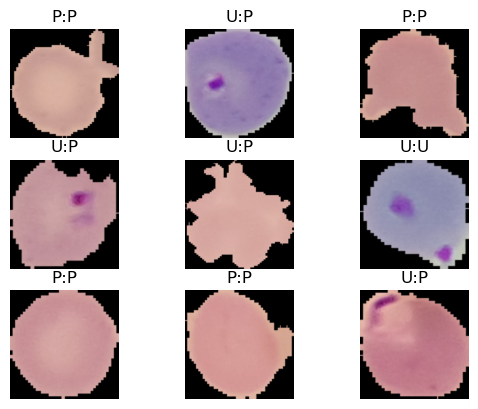

In [ ]:
for i, (image, label) in enumerate(test_dataset.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image[0])
    plt.title(parasite_or_not(label.numpy()[0]) + ':' + parasite_or_not(model.predict(test_dataset.take(1))[0][0]))
    plt.axis('off')

## Visualize Confusion Matrix

In [ ]:
labels = []
inp = []

for x, y in test_dataset.as_numpy_iterator():
    labels.append(y) 
    inp.append(x)


labels = np.array([i[0] for i in labels])
print(np.array(inp).shape, labels.shape)

(2755, 1, 224, 224, 3) (2755,)


In [ ]:
predicted = model.predict(np.array(inp)[:, 0, ...])
print(predicted[:, 0])


87/87 [==============================] - 2s 18ms/step
[0.97533673 0.97064596 0.9316219  ... 0.91433537 0.959271   0.93163383]


[[  64 1330]
 [   2 1359]]


Text(0.5, 58.7222222222222, 'Predicted')

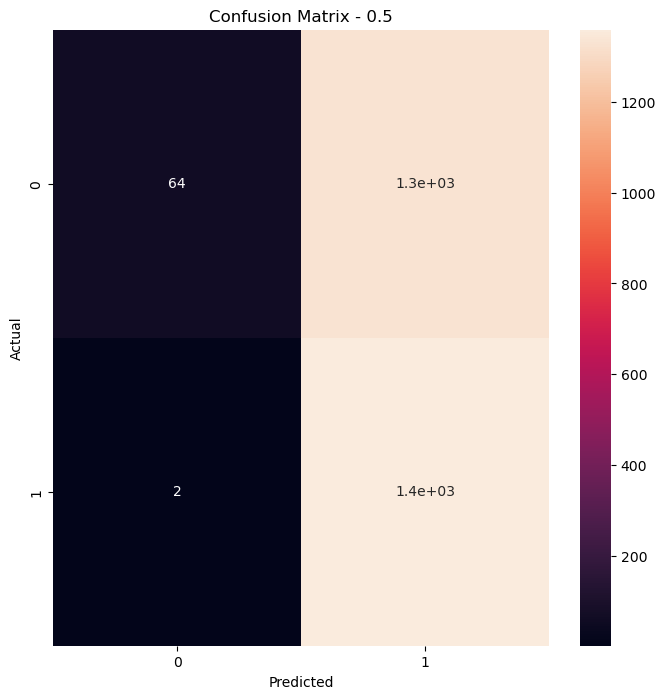

In [ ]:
threshold = 0.5

cm = confusion_matrix(labels, predicted > threshold)
print(cm)
plt.figure(figsize=(8, 8))

sns.heatmap(cm, annot=True,)
plt.title('Confusion Matrix - {}'.format(threshold))
plt.ylabel('Actual')
plt.xlabel('Predicted')


In [ ]:
# log the confusion matrix with wandb
pred = []

for i in range(len(predicted)):
    if predicted[i][0] < 0.5:
        pred.append([1,0])
    else:
        pred.append([0,1])


In [ ]:
print(pred)

[[0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1],

In [ ]:


pred = np.array(pred)
wandb.log({'confusion_matrix': wandb.plot.confusion_matrix(probs=pred,
                                                           y_true=labels,
                                                           class_names=['Parasitized', 'Uninfected'])})

wandb.log({'roc': wandb.plot.roc_curve(y_true=labels, y_probas=pred, labels=['Parasitized', 'Uninfected'])})

## ROC Plots

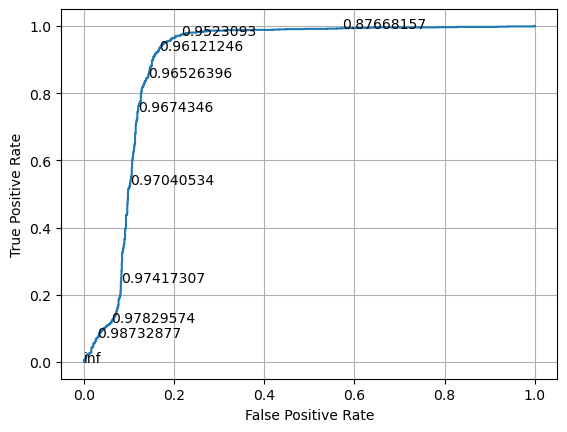

In [ ]:
fp, tp, thresholds = roc_curve(labels, predicted)

plt.plot(fp, tp, label='ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.grid()

skip = 50

for i in range(0, len(thresholds), skip):
    plt.text(fp[i], tp[i], thresholds[i])


plt.show()



## Loading and Saving the Model

In [ ]:
# model.save('malaria_detection')

In [ ]:
loaded_model = tf.keras.models.load_model('malaria_detection')

In [ ]:
loaded_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_4 (Bat  (None, 222, 222, 6)       24        
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 111, 111, 6)       0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_5 (Bat  (None, 109, 109, 16)      64        
 chNormalization)                                                
                                                      

wandb: Network error (TransientError), entering retry loop.
